In [211]:
import io
import os
import zipfile
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from pyproj import CRS, Transformer
from country_bounding_boxes import country_subunits_by_iso_code

In [216]:
url = 'https://records-ws.nbnatlas.org/occurrences/index/download'

# example parameters to add 

parameters = {
    'q': 'genus:Castor',
    'reasonTypeId': 10
}

# use requests.get to combine above into single GET url, print status code

r = requests.get(urls)

In [43]:
file = zipfile.ZipFile(io.BytesIO(r.content))

df = pd.read_csv(file.open('data.csv'), low_memory=False)

In [81]:
df = df[df['State/Province']=='Scotland']

In [83]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['Longitude (WGS84)'], df['Latitude (WGS84)']), crs=4326)

gdf = gdf.to_crs(27700)

In [49]:
crs_4326 = CRS.from_epsg(4326)
crs_27700 = CRS.from_epsg(27700)
transformer = Transformer.from_crs(crs_4326, crs_27700, always_xy=True)

In [88]:
scotland_bbox = [c.bbox for c in country_subunits_by_iso_code('GB')][2]

In [131]:
xmin, ymin, xmax, ymax = scotland_bbox

In [151]:
sw = transformer.transform(xmin, ymin)
ne = transformer.transform(xmax, ymax)

In [162]:
xlim, ylim = (sw[0], ne[0]), (sw[1],ne[1])

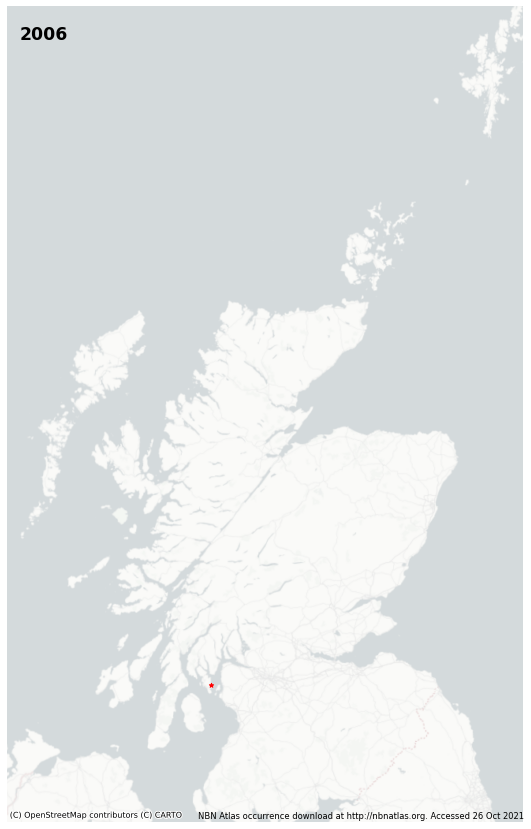

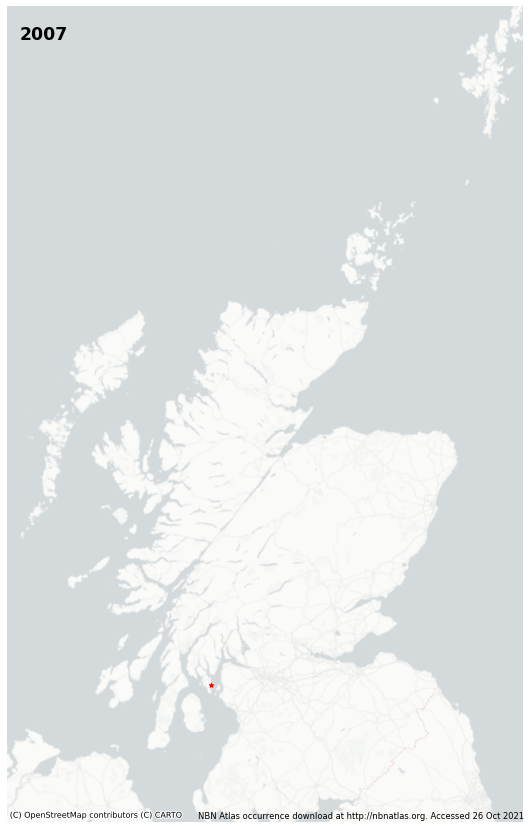

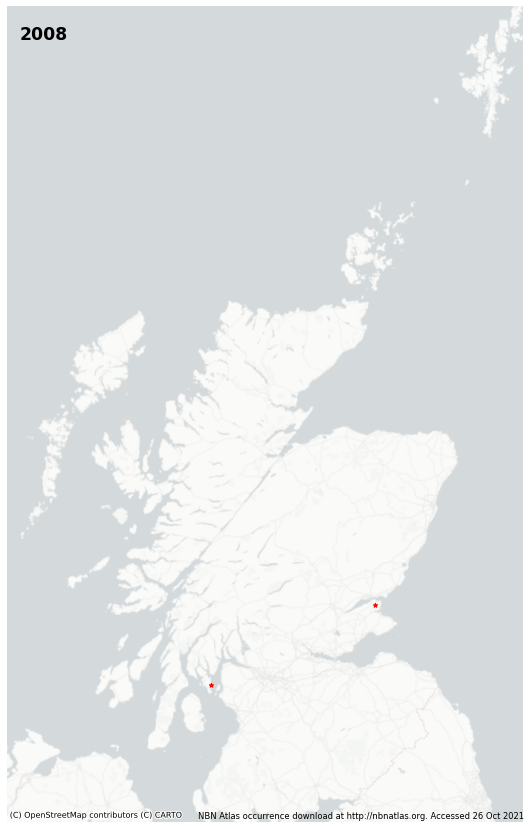

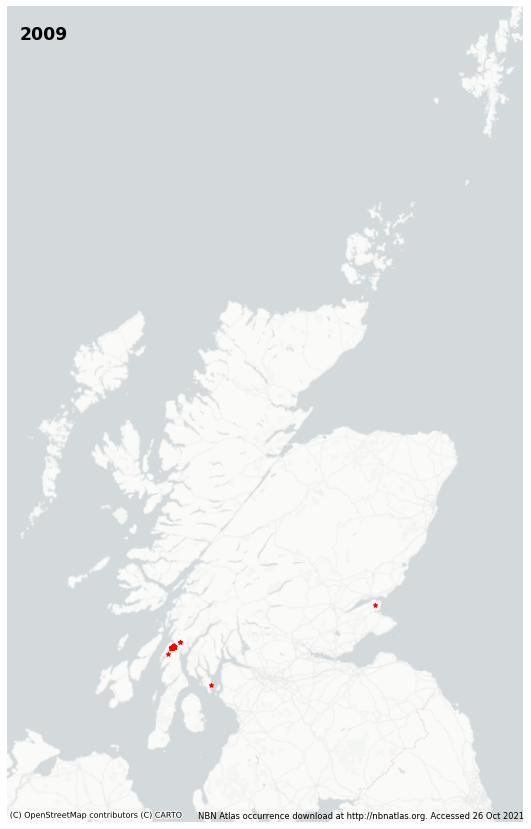

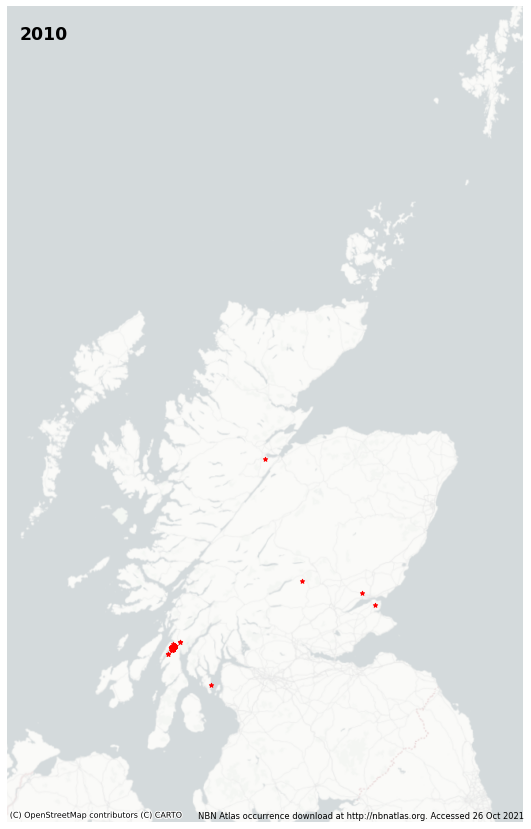

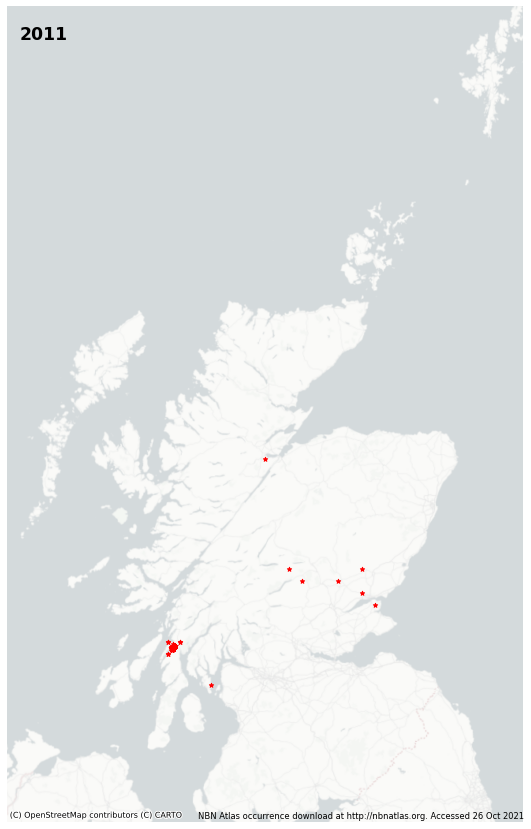

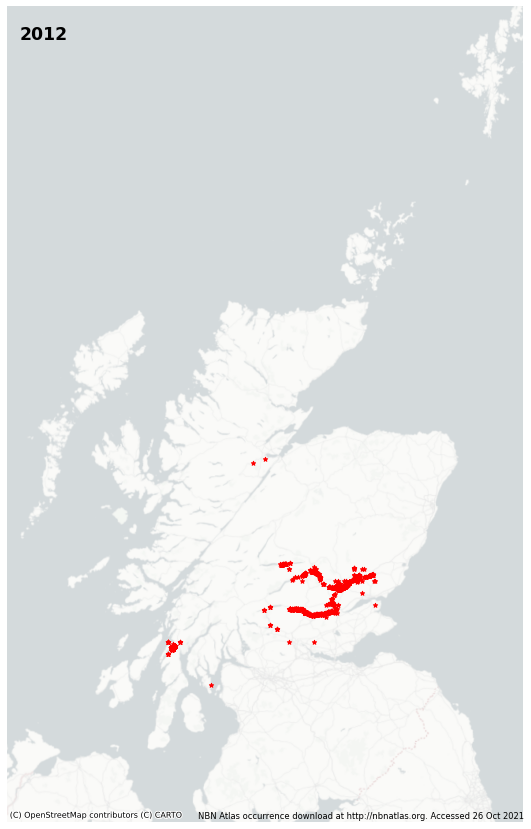

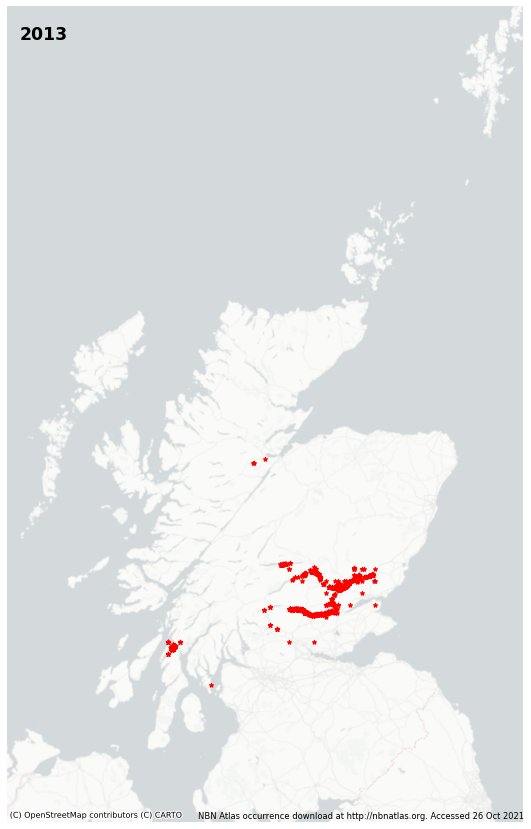

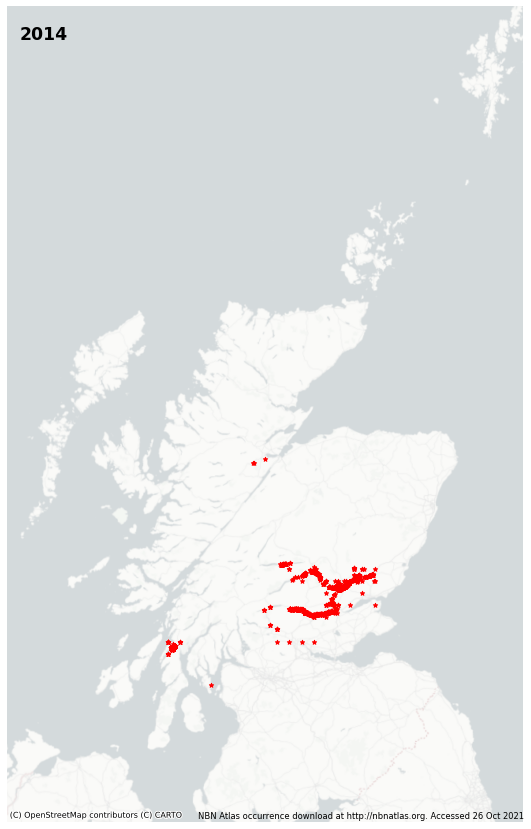

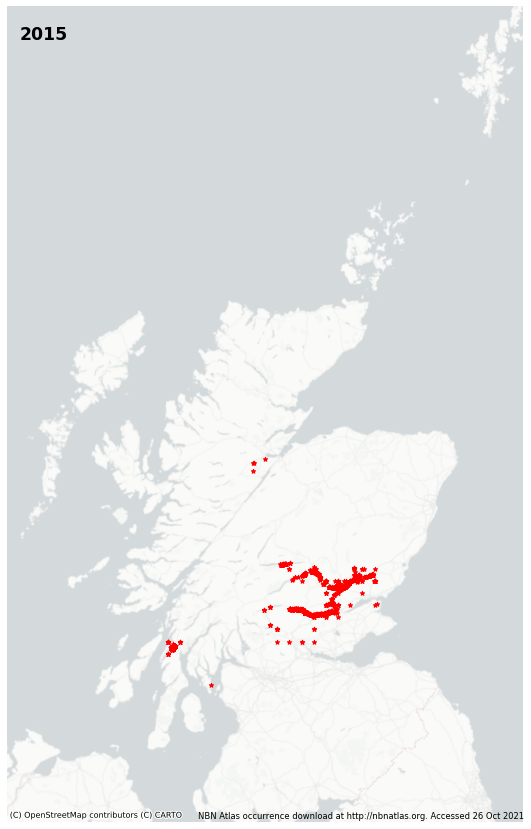

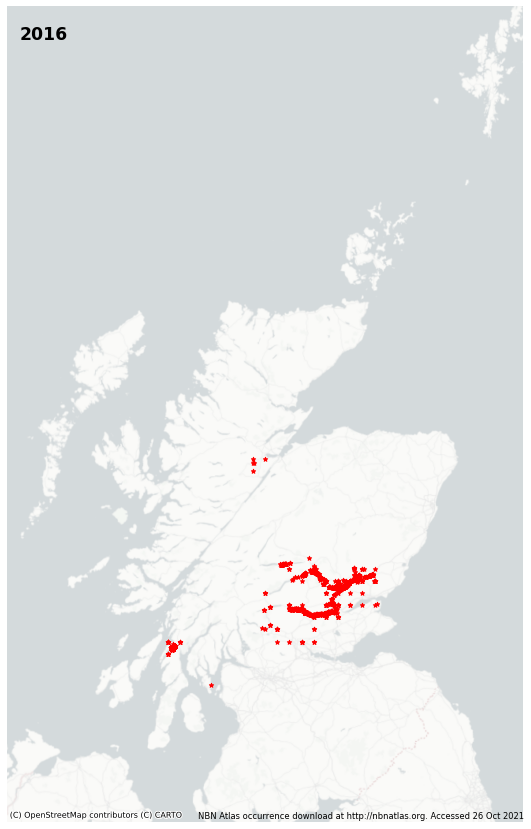

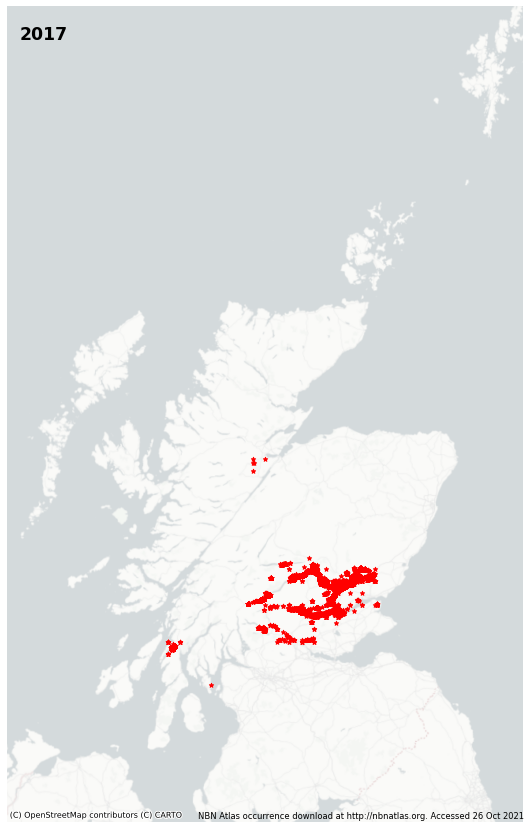

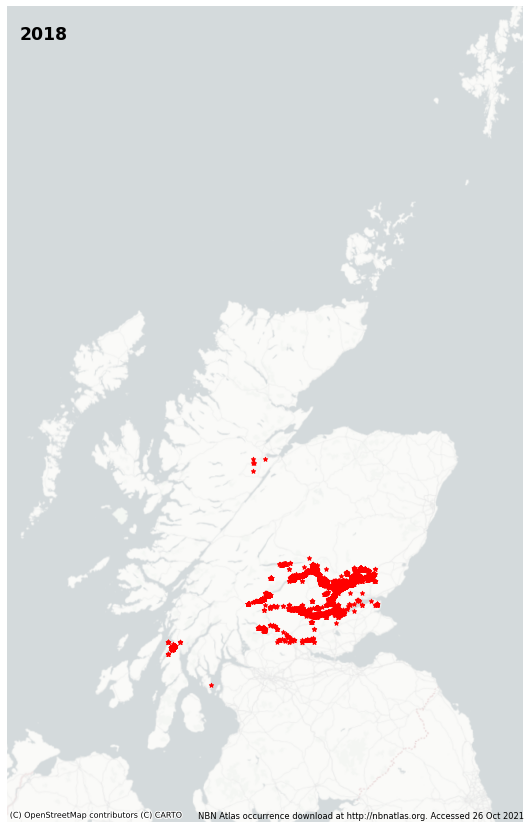

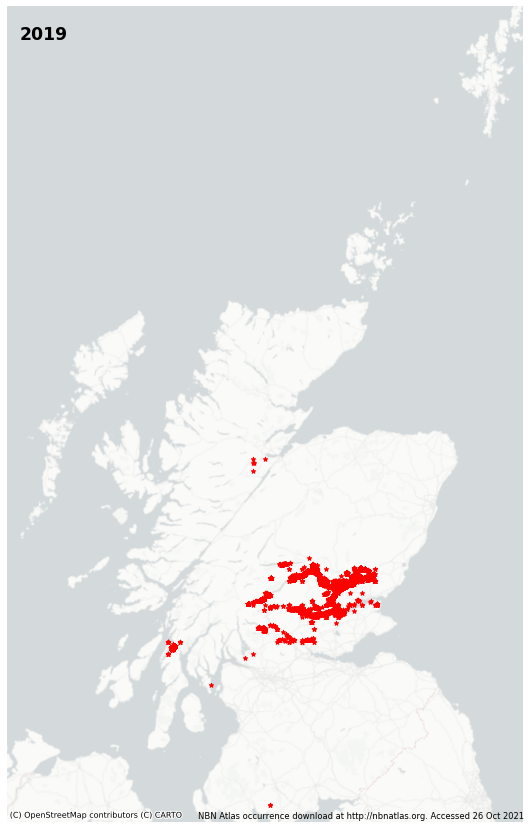

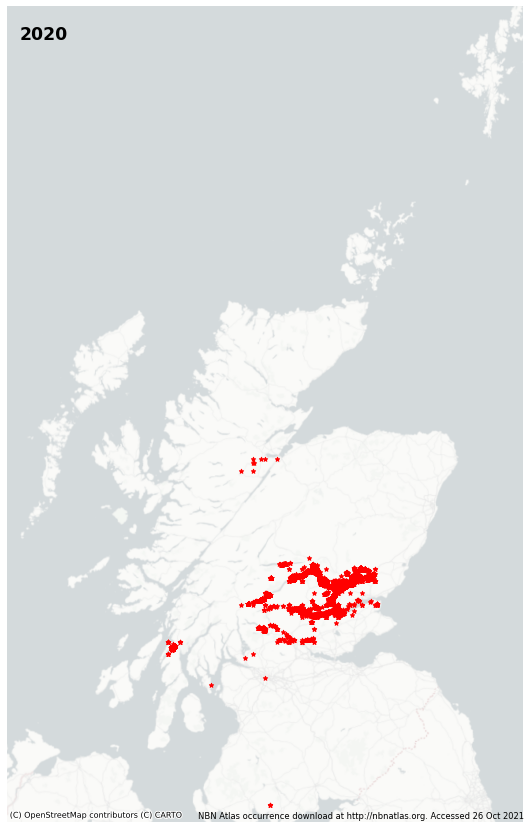

In [225]:
for i in range(2006,2021):
    fig, ax = plt.subplots(figsize=(15,15))
    gdf[gdf['Start date year'] <= i].plot(
        color='red',
        marker='*', markersize=20,
        ax = ax)
    
    #xlim = ([gdf.total_bounds[0],  gdf.total_bounds[2]])
    #ylim = ([gdf.total_bounds[1],  gdf.total_bounds[3]])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.text(0.025, 0.96, i, 
            transform = ax.transAxes, fontsize='xx-large', fontweight='bold', fontfamily='sans-serif')
    ax.set_axis_off()
    ax.text(0.37, 0.005, 'NBN Atlas occurrence download at http://nbnatlas.org. Accessed 26 Oct 2021', 
            transform = ax.transAxes, fontsize='small')
    cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.PositronNoLabels)
    plt.savefig(f'pngs/beaver_{str(i)}.png',bbox_inches='tight', dpi=200)
    plt.show()
    

In [231]:
# convert png files to gif and save
png_dir = 'pngs/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(Image.open(file_path))
images[0].save('beaver_pil.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)